# Laboratorio 2 - Visión por Computadora

- Diego Estuardo Lemus López - 21469
- José Pablo Kiesling Lange - 21581
- Herber Sebastián Silva Muñoz - 21764

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv

import skimage as ski
from skimage import morphology as mo

## 2. Consideramos de nuevo la imagen rice.jpg. Hacer lo siguiente

In [2]:
image_path = 'assets/rice.jpg'
image = plt.imread(image_path)
image_original = image

In [3]:
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

### a) Binarizar la imagen mediante el método de Otsu, o usando algún otro método no local

In [4]:
def otsu_threshold(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    pixnum = image.shape[0] * image.shape[1]
    
    prob = hist / pixnum

    max_var = 0
    threshold = 0

    sum_all = np.sum(np.arange(256) * prob)
    sum_background = 0
    sum_foreground = sum_all
    background = 0
    foreground = 1

    for t in range(1, 255):
        background += prob[t-1]
        foreground -= prob[t-1]

        if background == 0 or foreground == 0:
            continue
        
        sum_background += (t - 1) * prob[t - 1]
        sum_foreground -= (t - 1) * prob[t - 1]

        m0 = sum_background / background if background != 0 else 0
        m1 = sum_foreground / foreground if foreground != 0 else 0

        var = background * foreground * (m0 - m1) ** 2

        if var > max_var:
            max_var = var
            threshold = t

    return threshold

#### Equalización de la imagen

In [5]:
image_equalized = cv.equalizeHist(image)

#### Cuantización de la imagen (3)

In [6]:
N = 3
k = 256 // N
image_quantized = (image_equalized // k) * k

#### Segmentación binaria

In [7]:
threshold = otsu_threshold(image_quantized)
image_segmented = image_quantized > threshold

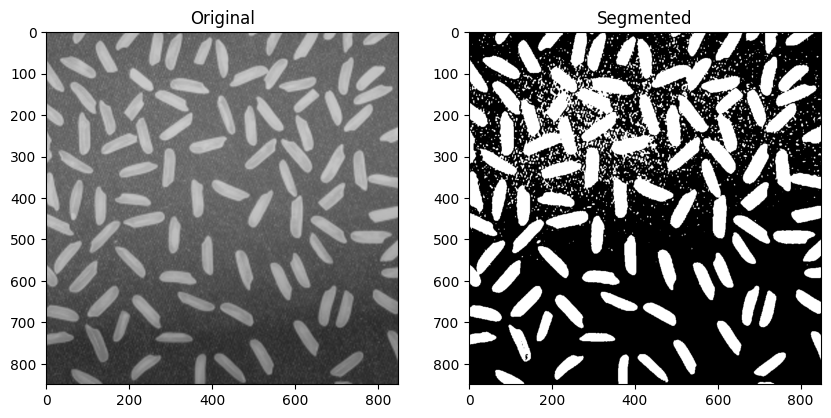

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(image_segmented, cmap='gray')
plt.title("Segmented")
plt.show()

### b) Aplicar operaciones morfológicas adecuadas para limpiar el ruido de la binarización. Explicar por qué está eligiendo estas transformaciones morfológicas.

#### opening para eliminar ruido

In [9]:
disk = mo.diamond(4)
image_open = mo.binary_opening(image_segmented, disk)

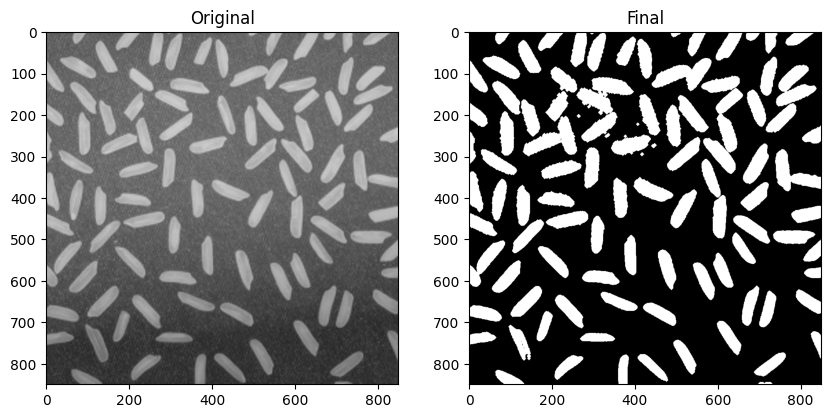

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_original, cmap='gray')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(image_open, cmap='gray')
plt.title("Final")
plt.show()